In [47]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta, graficar_ruta
from solvers_listos import generar_ruta, graficar_rutas 
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from instancia import crear_grafo_inicial

random.seed(42)
np.random.seed(42)

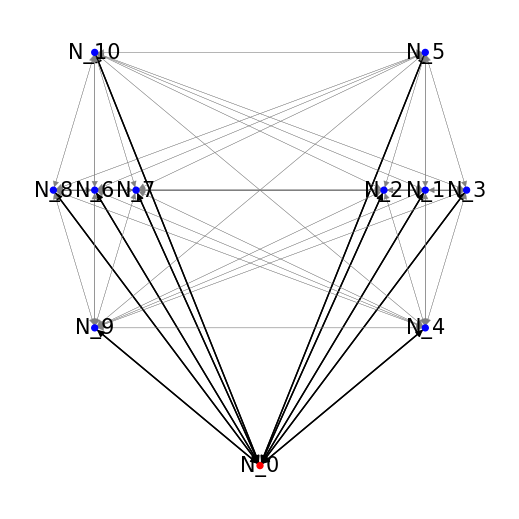

('N_0', {'Inv': 1428, 'Up': 100000, 'Low': 0, 'Prod': -581, 'h': 0.3, 'coord_x': 0, 'coord_y': 50, 'pos': (0, 50)})
('N_1', {'Inv': 87, 'Up': 174, 'Low': 0, 'Prod': 87, 'h': 0.23, 'coord_x': 200, 'coord_y': 100, 'pos': (200, 100)})
('N_2', {'Inv': 27, 'Up': 54, 'Low': 0, 'Prod': 27, 'h': 0.32, 'coord_x': 150, 'coord_y': 100, 'pos': (150, 100)})
('N_3', {'Inv': 20, 'Up': 30, 'Low': 0, 'Prod': 10, 'h': 0.33, 'coord_x': 250, 'coord_y': 100, 'pos': (250, 100)})
('N_4', {'Inv': 55, 'Up': 110, 'Low': 0, 'Prod': 55, 'h': 0.23, 'coord_x': 200, 'coord_y': 75, 'pos': (200, 75)})
('N_5', {'Inv': 142, 'Up': 213, 'Low': 0, 'Prod': 71, 'h': 0.18, 'coord_x': 200, 'coord_y': 125, 'pos': (200, 125)})
('N_6', {'Inv': 69, 'Up': 138, 'Low': 0, 'Prod': 69, 'h': 0.29, 'coord_x': -200, 'coord_y': 100, 'pos': (-200, 100)})
('N_7', {'Inv': 158, 'Up': 237, 'Low': 0, 'Prod': 79, 'h': 0.42, 'coord_x': -150, 'coord_y': 100, 'pos': (-150, 100)})
('N_8', {'Inv': 86, 'Up': 129, 'Low': 0, 'Prod': 43, 'h': 0.42, 'coord

In [48]:
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP2.xlsx' ,plot=True)
for nodo in G.nodes(data=True):
    print(nodo)

In [49]:
def reaccion_inventario(G, mu, sd, alfa = 0.05):
    """
    Función que verifica que locales deben ser visitados en base a su inventario actual. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
    
    return visitas

In [50]:
def IC_nrm(mu, sd, M=1000, alfa = 0.95):
    """
    Función que calcula el intervalo de confianza para una distribución normal.
    """
    limite_inferior = mu + norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    limite_superior = mu - norm.ppf((1 - alfa) / 2) * sd / math.sqrt(M)
    
    return limite_inferior, limite_superior

In [51]:
def simular_demanda_previa(G, dist = 'n', T =100, ruido = 0):
    """
    Función que simula la demanda previa de los locales.
    """
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    # r = {nodo : nodo[1]['Prod'] for nodo in G.nodes(data=True)}
    if dist == 'n':
        for nodo in G.nodes(data=True):
            # print(nodo[0],nodo[1]['Prod'])
            if nodo[0] != 'N_0':
                dem_pasadas = [max(
                    np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                    + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * ruido)
                    ,0) for _ in range(T)]
                demandas[nodo[0]] = dem_pasadas
         
    return demandas

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#ejemplo demanda historica

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [52]:
def SEDA(datos, historia = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Suavizamiento Exponencial Doble Amortiguado
    Aplica el método de suavizamiento exponencial doble a una serie de datos,
    específicmamente el Método de Holt Damped.
    '''
    I = [datos[0]]
    S = [datos[1]-datos[0]]
    for i in range(1,len(datos)):
        I.append(alpha*datos[i] + (1-alpha)*(I[i-1]+ theta*S[i-1]))
        S.append(beta*(I[i]-I[i-1])+(1-beta)*S[i-1])
    
    y = I[-1] + theta * S[-1]
    if historia == False:
        return y
    elif historia == True:
        I.append(y)
        return I
    elif historia == 'S':
        return I, S
    
def pronostico_SEDA(datos, T, pron = False, alpha=0.1, beta=0.1, theta=0.5):
    '''
    Devuelve un pronóstico para los siguientes T periodos mediante Suavizamiento Exponencial Doble Amortiguado
    '''
    I,S = SEDA(datos, historia = 'S', alpha=alpha, beta=beta, theta=theta)
    pronostico = []
    for i in range(T):
        y = I[-1] + theta * S[-1]
        pronostico.append(y)
        I.append(alpha*y + (1-alpha)*(I[-1]+ theta*S[-1]))
        S.append(beta*(I[-1]-I[-2]) + (1-beta)*S[-1])
    
    return pronostico

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [53]:
for nodo in G.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 1428
N_1 87
N_2 27
N_3 20
N_4 55
N_5 142
N_6 69
N_7 158
N_8 86
N_9 77
N_10 126


In [54]:
def ejecutar_ruta(G,ruta,matriz_dst):
    """
    Función que simula la ejecución de una ruta.
    """
    ruta = ruta.copy()
    ruta.pop(0)
    ruta.pop(-1)
    ruta = [int(nodo[2:]) for nodo in ruta]
    # distancia = calcular_largo_ruta(ruta, matriz_dst)
    stock = 0
    for nodo in ruta:
        stock += G.nodes[f'N_{nodo}']['Up'] - G.nodes[f'N_{nodo}']['Inv']
        G.nodes[f'N_{nodo}']['Inv'] = G.nodes[f'N_{nodo}']['Up']
    G.nodes['N_0']['Inv'] -= stock
    return G, stock

def realizacion_demanda(G, ruido = 0.05):
    """
    Función que simula la demanda de los locales para un determinado periodo.
    """
    grafo = G.copy()
    demandas = {nodo : [] for nodo in G.nodes() if nodo != 'N_0'}
    insatisfecho = 0
    for nodo in grafo.nodes(data=True):
        if nodo[0] != 'N_0':
            dem = max(
                np.random.normal(loc = nodo[1]['Prod'], scale = nodo[1]['Prod'] * 0.05) 
                + np.random.normal(loc = 0, scale = nodo[1]['Prod'] * 0.05)
                ,0)
            demandas[nodo[0]] = dem
            if dem <= grafo.nodes[nodo[0]]['Inv']:
                grafo.nodes[nodo[0]]['Inv'] -= dem
            else:
                grafo.nodes[nodo[0]]['Inv'] = 0
                insatisfecho += dem - grafo.nodes[nodo[0]]['Inv']

    return grafo, demandas, insatisfecho
Gprima, d, ins = realizacion_demanda(G)

for nodo in Gprima.nodes(data=True):
    print(nodo[0],nodo[1]['Inv'])

N_0 1428
N_1 0
N_2 0
N_3 10.234145165836257
N_4 0
N_5 70.7405459153389
N_6 3.205558690020382
N_7 85.60170599371247
N_8 47.91749152777111
N_9 2.6895475827957256
N_10 70.30903249709797


In [55]:
dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
vis = reaccion_inventario(G, mu_d, sd_d)
np.sum(mu_d)

581.2713867204681

Inventario inicial: 
N_0 1428
N_1 87
N_2 27
N_3 20
N_4 55
N_5 142
N_6 69
N_7 158
N_8 86
N_9 77
N_10 126


No hay locales que visitar
Ruta 1:  ['N_0', 'N_2', 'N_4', 'N_1', 'N_5', 'N_10', 'N_6', 'N_9', 'N_0']
Ruta 2:  ['N_0', 'N_3', 'N_1', 'N_2', 'N_7', 'N_9', 'N_8', 'N_0']
Ruta 3:  ['N_0', 'N_4', 'N_1', 'N_2', 'N_9', 'N_6', 'N_10', 'N_0']
Ruta 4:  ['N_0', 'N_8', 'N_7', 'N_4', 'N_1', 'N_5', 'N_0']


Inventario final: 
N_0 -1258.055597611692
N_1 88.58942420797375
N_2 4.021343140296061
N_3 0.48619189797432405
N_4 56.29621016954717
N_5 150.81400825108113
N_6 6.658379417873192
N_7 161.00299841760923
N_8 85.45651299109085
N_9 8.110469429348555
N_10 58.38360704022753
Demanda perdida total: 315.8735163927232 | Demanda perdida promedio: 63.17470327854464
dict_values(['red', 'black', 'purple', 'orange', 'orange', 'purple', 'red', 'black', 'purple', 'black', 'orange', 'red', 'orange', 'red', 'purple', 'black', 'orange', 'black', 'orange', 'red', 'black', 'purple', 'red', 'purple'])


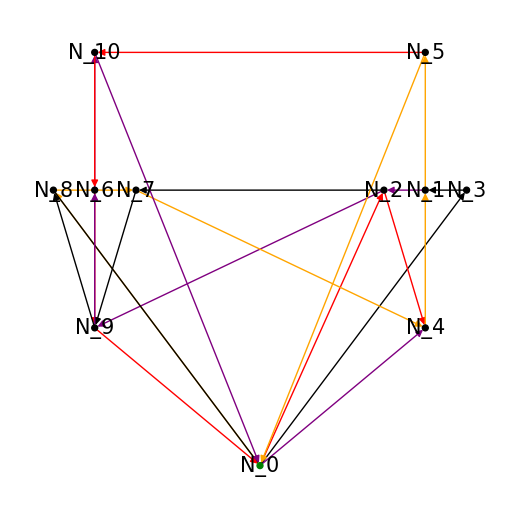

In [56]:
def simular_ejecucion_R(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        # print("Visitas reacción: ", visitas_reaccion)
        
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        perdido += insatisfecho

        inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]

        costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])
    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')
    # print(rutas)
        
        
simular_ejecucion_R(grafo_inicial = G, T = 500)
        

In [57]:
def proactiva_inventario(G, pronostico):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
            
    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_sup
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas

In [58]:
def simular_ejecucion_P(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.2, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]
        # for i in range(len(pronostico)):
        #       print(f"Pronóstico: N_{i+1}, {pronostico[i]}") 
         
        visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        print("Visitas reacción: ", visitas_proactiva)
        
        ruta_R, largo_ruta = generar_ruta(G0, matriz_dst, visitas_proactiva) #devuelve la ruta a realizar

        G0 = ejecutar_ruta(G0, ruta_R, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)

        # Estrategia Proactiva (P)
        
        
        
simular_ejecucion_P(grafo_inicial = G, T = 1)

Inventario inicial: 
N_0 1428
N_1 87
N_2 27
N_3 20
N_4 55
N_5 142
N_6 69
N_7 158
N_8 86
N_9 77
N_10 126




TypeError: proactiva_inventario() got an unexpected keyword argument 'tolerancia'

In [ ]:
G.nodes(data=True)['N_0']['Inv']